# CIFAR10: Training a classifer

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lento234/ml-tutorials/blob/main/01-basics/CIFAR10.ipynb)

**References**:
- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

**Runtime setup: GPU accelerator at Google colab:**

1. On the main menu, click **Runtime** and select **Change runtime type**. 
2. Select **GPU** as the hardware accelerator.


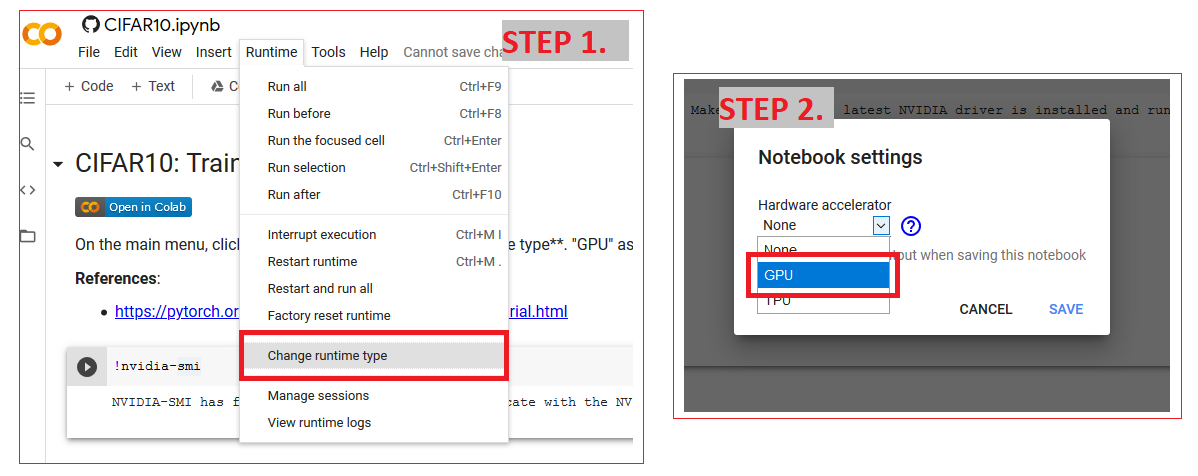

![steps](../images/steps.png)

In [1]:
!nvidia-smi

Thu Jan 14 14:35:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:03:00.0 Off |                  N/A |
| 24%   27C    P8     2W / 260W |    197MiB / 11010MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Table of content**

1. [Load and pre-process the dataset](#load)
2. [Define the CNN model](#define)
3. [Define the loss function and optimizer](#loss)
4. [Train the model on **training** dataset](#train)
5. [Test/Validate the model on **test** dataset](#validate)

**CIFAR10 Dataset**

The dataset consists of `3x32x32` images of 10 difference classes:

    airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.

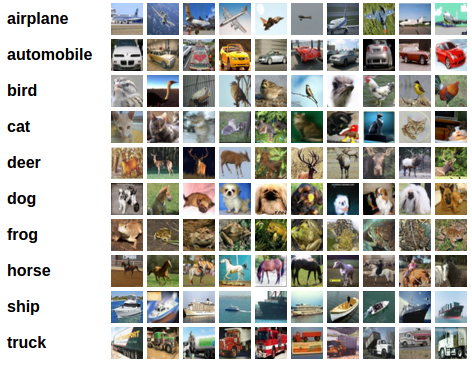

## Setup

### Environment

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

### Computing platform: CPU vs. GPU

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Computing with <<{device}>>")

Computing with <<cuda>>


### Hyper-parameters

In [4]:
batch_size = 16
num_workers = 4
num_epochs = 5
learning_rate = 0.001
momentum = 0.9

<a id='load'></a>
## 1. Load and pre-process data

- Define preprocessing algorithm
- Load training and test dataset

### 1.1 Define preprocessing algorithm

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(), # convert data to pytorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalize dataset for each channel
])

### 1.2 Load training and test dataset

In [6]:
# Download train and test dataset
train_dataset = datasets.CIFAR10(root='./data', train=True,
                                 download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, 
                                 download=True, transform=transform)

# Dataset sampler (shuffle, distributed loading)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                          shuffle=False, num_workers=num_workers)

print(f"num. examples: train = {len(train_dataset)}, test = {len(test_dataset)}")

0it [00:00, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
num. examples: train = 50000, test = 10000


In [7]:
classes = np.array(['plane', 'car', 'bird', 'cat', 'deer',
                    'dog', 'frog', 'horse', 'ship', 'truck'])

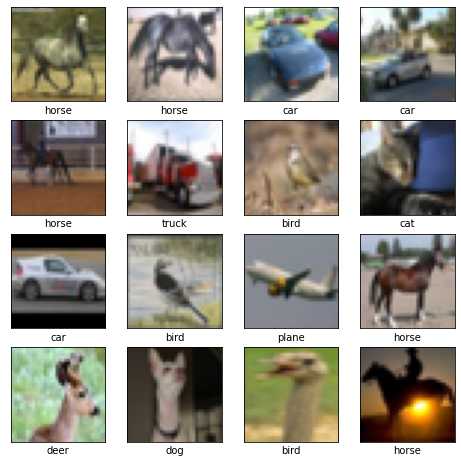

In [8]:
def imshow(images, labels):    
    plt.figure(figsize=(8,8))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = images[i] / 2 + 0.5 # unnormalize
        plt.imshow(np.transpose(img.numpy(), (1, 2, 0)), cmap=plt.cm.binary)
        plt.xlabel(labels[i])
    plt.show()
    
# get some random training images
images, labels = next(iter(train_loader))

# show images
imshow(images, classes[labels])

<a id=define></a>
## 2. Define the CNN model

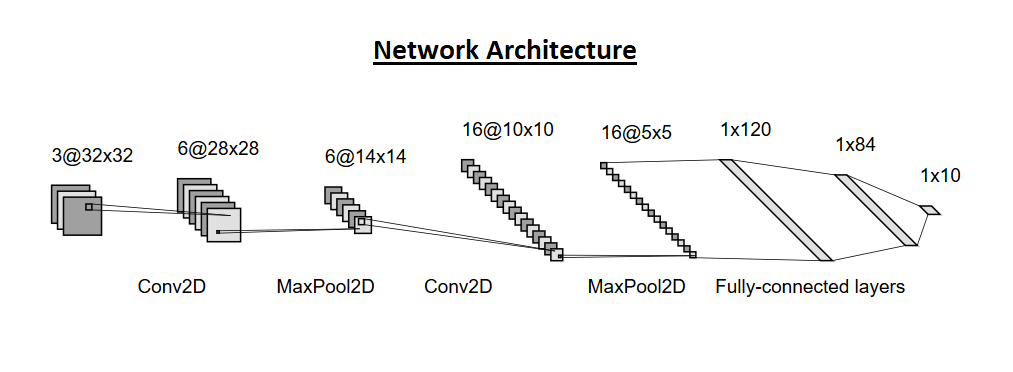

**Architecture:**

- Input: An image of `n_channels=3`.
- Two layer stacks of 2D convolutional layers (`Conv2d` with `kernel_size=5`) with rectified linear activation (`ReLU`) followed by a  2D max pooling (`MaxPool2D` with `kernel_size=2` and `stride=2`)
- Three layer stacks of Fully-connected layers (`Linear`) with ReLU activaton.
- Output: 10-dimensional vector defining the activation of each class

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define network
        self.layer1 = nn.Sequential(nn.Conv2d(3, 6, kernel_size=5),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 =  nn.Sequential(nn.Conv2d(6, 16, kernel_size=5),
                                     nn.ReLU(),
                                     nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(nn.Flatten(),
                                    nn.Linear(16 * 5 * 5, 120),
                                    nn.ReLU())
        self.layer4 = nn.Sequential(nn.Linear(120, 84),
                                    nn.ReLU())
        self.layer5 = nn.Linear(84, 10)
        

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        return x

In [10]:
model = Net().to(device)
print(model)

Net(
  (layer1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=400, out_features=120, bias=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
  )
  (layer5): Linear(in_features=84, out_features=10, bias=True)
)


<a id=loss></a>
## 3. Define the loss function and optimizer

In [11]:
# loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

print("loss:", criterion)
print("optimizer:", optimizer)

loss: CrossEntropyLoss()
optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


<a id=train></a>
## 4. Train the model on **training** dataset

In [12]:
loss_history = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (x_train, y_train) in tqdm(enumerate(train_loader), 
                                              desc=f"[Epoch {epoch}]",
                                              total=len(train_loader)):
        # Send batch to device
        x_train, y_train = x_train.to(device), y_train.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward-pass
        y_pred = model(x_train)
        
        # backward propogation
        loss = criterion(y_pred, y_train)
        loss.backward()
        
        # optimize
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    loss_history.append(running_loss / len(train_loader))
print('Finished Training')


[Epoch 0]: 100%|██████████| 3125/3125 [00:19<00:00, 161.04it/s]

[Epoch 1]: 100%|██████████| 3125/3125 [00:17<00:00, 176.67it/s]

[Epoch 2]: 100%|██████████| 3125/3125 [00:18<00:00, 170.67it/s]

[Epoch 3]: 100%|██████████| 3125/3125 [00:18<00:00, 170.29it/s]

[Epoch 4]: 100%|██████████| 3125/3125 [00:17<00:00, 176.45it/s]

Finished Training


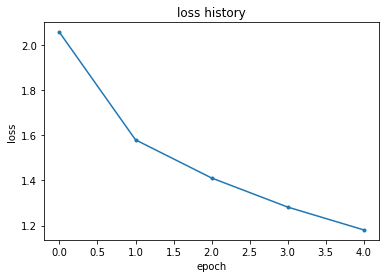

In [13]:
fig, ax = plt.subplots()
ax.plot(loss_history, '.-')
ax.set(xlabel='epoch', ylabel='loss',
       title='loss history');

<a id="validate"></a>
## 5. Test/Validate the model on **test** dataset

### 5.1 Predict using the trained model

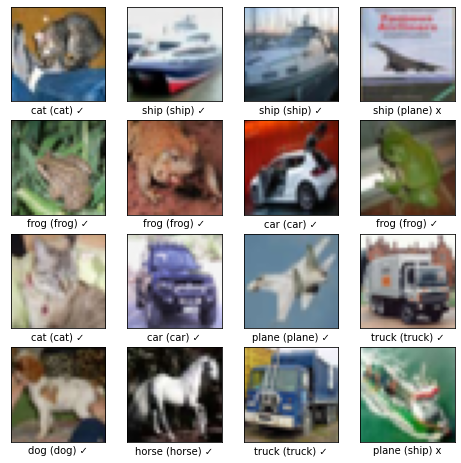

In [14]:
images, labels = next(iter(test_loader))

# predict
prediction = model(images.to(device))
prediction = prediction.cpu() # gpu -> cpu
predicted_labels = torch.argmax(prediction, 1).detach()

# print images
imshow(images, ["{} ({}) {}".format(classes[pred], classes[gt], "✓" if pred == gt else "x")
                for pred, gt in zip(predicted_labels, labels)])

### 5.2. Accuracy of the model on **test** dataset

In [15]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(test_loader, total=len(test_loader)):
        prediction = model(images.to(device)).cpu()
        predicted_labels = torch.argmax(prediction, 1)
        total += predicted_labels.size(0)
        correct += (predicted_labels == labels).sum().item()

print('Accuracy on {} test images: {}%'.format(
    len(test_loader)*batch_size,
     100 * correct / total))


100%|██████████| 625/625 [00:01<00:00, 435.44it/s]

Accuracy on 10000 test images: 58.26%


### 5.3 Accuracy of the model per class

In [16]:
class_correct = np.zeros(len(classes))
class_total = np.zeros(len(classes))
with torch.no_grad():
    for images, labels in tqdm(test_loader, total=len(test_loader)):
        prediction = model(images.to(device)).cpu()
        predicted_labels = torch.argmax(prediction, 1)
        c = (predicted_labels == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

sorted_idx = np.argsort(class_correct/class_total)[::-1]
for i in sorted_idx:
    print('Accuracy of {:5s}: {}%'.format(
           classes[i], 100 * class_correct[i] / class_total[i]))
    


100%|██████████| 625/625 [00:01<00:00, 367.10it/s]

Accuracy of ship : 79.6%
Accuracy of car  : 76.5%
Accuracy of frog : 68.7%
Accuracy of plane: 66.0%
Accuracy of horse: 63.5%
Accuracy of truck: 56.7%
Accuracy of bird : 48.7%
Accuracy of dog  : 43.4%
Accuracy of cat  : 42.9%
Accuracy of deer : 36.6%
